In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import utils
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from time import perf_counter

In [2]:
df = pd.DataFrame(pd.read_csv("heart_failure_clinical_records_dataset.csv"))

In [3]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Cantidad de observaciones por clase
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64


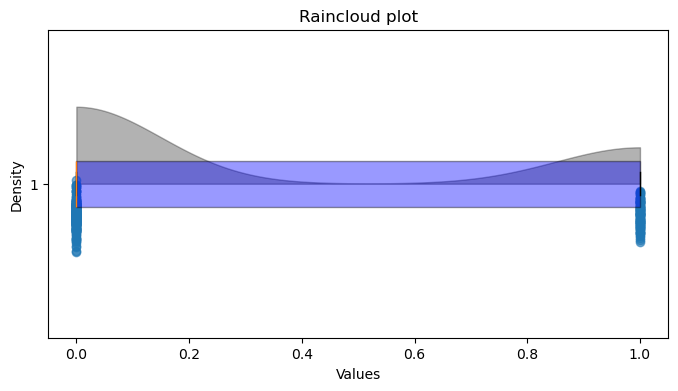

In [5]:
print('Cantidad de observaciones por clase')
print(df['DEATH_EVENT'].value_counts())
fig, ax = plt.subplots(figsize=(8, 4))
data_x = df['DEATH_EVENT']

# Create a list of colors for the boxplots based on the number of features you have
boxplots_colors = ['blue', 'red']

# Boxplot data
bp = ax.boxplot(data_x, patch_artist = True, vert = False)

# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], boxplots_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Create a list of colors for the violin plots based on the number of features you have
violin_colors = ['black', 'black']

# Violinplot data
vp = ax.violinplot(data_x, points=500,
               showmeans=False, showextrema=False, showmedians=False, vert=False)

for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
    # Change to the desired color
    b.set_color(violin_colors[idx])

# Crear scatter plot horizontal
scatter_data = data_x
y = np.random.normal(1, 0.04, size=len(scatter_data)) - 0.1
plt.scatter(scatter_data, y, alpha=0.6)

# plt.yticks(np.arange(1,1,1), ['Feature 1', 'Feature 2'])  # Set text labels.
plt.xlabel('Values')
plt.ylabel('Density')
plt.title("Raincloud plot")
plt.show()

In [6]:
df = df.rename({'DEATH_EVENT':'label'}, axis=1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['label'],axis=1),df['label'],test_size=0.33,random_state=0)
x_train.shape,x_test.shape

((200, 12), (99, 12))

In [8]:
y_test.value_counts()

label
0    68
1    31
Name: count, dtype: int64

In [9]:
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(x_train)
x_train = pd.DataFrame(norm(x_train))
# norm.adapt(x_test)
x_test = pd.DataFrame(norm(x_test))

In [10]:
import optuna
# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
                 init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type):

    if regularizer_type == "l1":
        regularizer = keras.regularizers.l1(0.01)
    elif regularizer_type == "l2":
        regularizer = keras.regularizers.l2(0.01)
    else:
        regularizer = None


    model = keras.Sequential([
        keras.layers.Dense(1024, input_shape=(x_train.shape[1],), activation=activation_1,
                           kernel_initializer=init_mode_1, kernel_regularizer=regularizer_type),
        keras.layers.Dense(512, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(256, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(128, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(64, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(1, activation=activation_6, kernel_initializer=init_mode_6),
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

# Función objetivo para Optuna
def objective(trial):

    regularizer_type = trial.suggest_categorical('regularizer_type', [None, "l1", "l2"])

    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)

    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)

    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
                 init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type)
    EarlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_accuracy', patience = 100, mode = 'max', restore_best_weights = True)
    history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=0, callbacks=EarlyStop)

    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['val_binary_accuracy'][-1]
    return val_loss
start=perf_counter()
# Iniciar la optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Mejores hiperparámetros:", study.best_params)
tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

[I 2024-01-30 19:12:35,974] A new study created in memory with name: no-name-e14fde21-5133-401b-b923-762ca63c6cca
[I 2024-01-30 19:12:42,385] Trial 0 finished with value: 0.31313130259513855 and parameters: {'regularizer_type': None, 'activation_1': 'tanh', 'activation_2': 'selu', 'activation_3': 'sigmoid', 'activation_4': 'elu', 'activation_5': 'softsign', 'activation_6': 'softmax', 'init_mode_1': 'he_normal', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'glorot_normal', 'init_mode_4': 'he_uniform', 'init_mode_5': 'normal', 'init_mode_6': 'he_normal'}. Best is trial 0 with value: 0.31313130259513855.
[I 2024-01-30 19:12:52,063] Trial 1 finished with value: 0.7676767706871033 and parameters: {'regularizer_type': 'l2', 'activation_1': 'relu', 'activation_2': 'sigmoid', 'activation_3': 'softplus', 'activation_4': 'hard_sigmoid', 'activation_5': 'exponential', 'activation_6': 'softplus', 'init_mode_1': 'he_normal', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'glorot_normal', 'init_mo

Mejores hiperparámetros: {'regularizer_type': 'l2', 'activation_1': 'swish', 'activation_2': 'sigmoid', 'activation_3': 'softplus', 'activation_4': 'hard_sigmoid', 'activation_5': 'tanh', 'activation_6': 'softplus', 'init_mode_1': 'normal', 'init_mode_2': 'he_uniform', 'init_mode_3': 'he_normal', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'normal', 'init_mode_6': 'he_normal'}
Elapsed time: 16.20 min.


In [11]:
dicc = study.best_params
dicc

{'regularizer_type': 'l2',
 'activation_1': 'swish',
 'activation_2': 'sigmoid',
 'activation_3': 'softplus',
 'activation_4': 'hard_sigmoid',
 'activation_5': 'tanh',
 'activation_6': 'softplus',
 'init_mode_1': 'normal',
 'init_mode_2': 'he_uniform',
 'init_mode_3': 'he_normal',
 'init_mode_4': 'glorot_uniform',
 'init_mode_5': 'normal',
 'init_mode_6': 'he_normal'}

In [12]:
if dicc['regularizer_type'] == 'None':
    dicc['regularizer_type'] = None
    
model = tf.keras.Sequential([
    keras.layers.Dense(1024, input_shape=(x_train.shape[1],), activation = dicc['activation_1'], kernel_initializer=dicc['init_mode_1'], kernel_regularizer=dicc['regularizer_type']),
    keras.layers.Dense(512, activation=dicc['activation_2'], kernel_initializer=dicc['init_mode_2']),
    keras.layers.Dense(256, activation=dicc['activation_3'], kernel_initializer=dicc['init_mode_3']),
    keras.layers.Dense(128, activation=dicc['activation_4'], kernel_initializer=dicc['init_mode_4']),
    keras.layers.Dense(64, activation=dicc['activation_5'], kernel_initializer=dicc['init_mode_5']),
    keras.layers.Dense((df['label'].nunique()-1), activation=dicc['activation_6'], kernel_initializer=dicc['init_mode_6'])
])

model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = keras.metrics.BinaryAccuracy()
)

EarlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_accuracy', patience = 250, mode = 'max', restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 1000, validation_data=(x_test, y_test), callbacks=EarlyStop)

model.evaluate(x_test, y_test)

Epoch 1/1000
7/7 [==============================] - 1s 36ms/step - loss: 0.9843 - binary_accuracy: 0.6000 - val_loss: 0.8540 - val_binary_accuracy: 0.6869
Epoch 2/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.8539 - binary_accuracy: 0.6750 - val_loss: 0.7917 - val_binary_accuracy: 0.6869
Epoch 3/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.8052 - binary_accuracy: 0.7500 - val_loss: 0.7209 - val_binary_accuracy: 0.6869
Epoch 4/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.6787 - binary_accuracy: 0.7450 - val_loss: 0.6361 - val_binary_accuracy: 0.7071
Epoch 5/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.6249 - binary_accuracy: 0.8000 - val_loss: 0.7974 - val_binary_accuracy: 0.8384
Epoch 6/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.6911 - binary_accuracy: 0.8250 - val_loss: 0.8452 - val_binary_accuracy: 0.8182
Epoch 7/1000
7/7 [==============================] - 0s 15ms/step - los

[0.5608489513397217, 0.8585858345031738]

4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.86      0.96      0.90        68
           1       0.87      0.65      0.74        31

    accuracy                           0.86        99
   macro avg       0.86      0.80      0.82        99
weighted avg       0.86      0.86      0.85        99



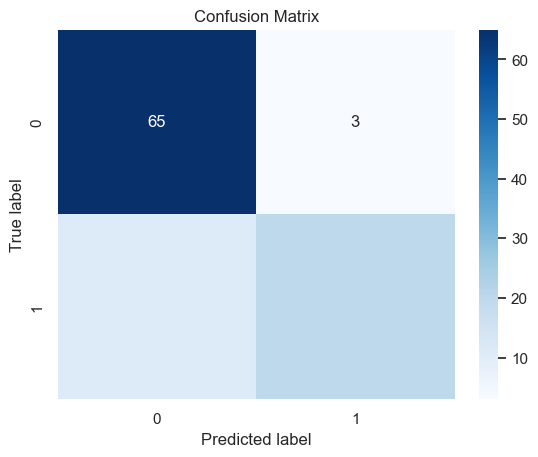

In [13]:
target_names = ['0', '1']
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
sns.set(font_scale=1.0)

sns.heatmap(cm_df, cmap='Blues',annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [15]:
from sklearn.metrics import f1_score
print('F1-score')
print(f1_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='weighted'))
     

F1-score
0.8217592592592593
0.8585858585858586
0.8520389075944631
